In [1]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, download_orekit_data_curdir

from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import Constants, IERSConventions, PVCoordinates
from org.orekit.propagation.analytical.tle import TLE,TLEPropagator
from org.orekit.orbits import KeplerianOrbit, PositionAngleType
from math import radians, pi, degrees
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from org.orekit.propagation.analytical import EcksteinHechlerPropagator, KeplerianPropagator

from org.hipparchus.geometry.euclidean.threed import Vector3D


# from org.orekit.sensors import FieldOfView, ImagingSensor, ObservationSensor
#  /// initialization of package
vm  = orekit.initVM()
# download_orekit_data_curdir()    # download the orkeit-data for once 
setup_orekit_curdir()



OpenJDK 64-Bit Server VM warning: Attempt to protect stack guard pages failed.
OpenJDK 64-Bit Server VM warning: Attempt to deallocate stack guard pages failed.


In [2]:
from org.orekit.geometry.fov import CircularFieldOfView, FieldOfView
from org.orekit.propagation.events import FieldOfViewDetector, ElevationDetector, BooleanDetector, EventsLogger
from datetime import datetime, timedelta
from org.orekit.propagation.events.handlers import ContinueOnEvent

from org.orekit.attitudes import NadirPointing

# from math import degrees
from org.orekit.frames import Transform
from org.hipparchus.geometry import Vector

import numpy as np

import json
from shapely.geometry import Point, Polygon, GeometryCollection
from shapely.geometry import MultiPoint, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape

from java.util import List
from datetime import datetime, timedelta

In [3]:
# config, 
"""we are taking the irridium 178 polar walker constellation satellite tle information for this project and 
    changes the orbital elemenets, as per research required.
"""
# TLE information

# The orbital elements written as strings in a TLE are mean ones according to the SGP4 theory.

# IRIDIUM 178
line1="1 56729U 23068V   24154.47728178  .00000642  00000-0  81118-4 0  9993"
line2= "2 56729  86.5773 339.2187 0002054  81.2330 278.9124 14.80208184 56200"


In [4]:
# Some important function 

#  function to parse the tle to keplarian elements
def parse_tle(line1, line2): 
    #this function will take the tle information (line1, line2) and return the dict value of keplerian orbital parameters formated as
    """
       {
       'mean_motion': ,
       'eccentricity': ,
       'inclination': ,
       'right_ascension': ,
       'argument_of_perigee': ,
       'mean_anomaly': ,
       'semi_major_axis': 
       }
    """

    
    keplerian = {}
    
    keplerian['mean_motion'] = float(line2[52:63])
    keplerian['eccentricity'] = float('0.' + line2[26:33])
    keplerian['inclination'] = float(line2[8:16])
    keplerian['right_ascension'] = float(line2[17:25])
    keplerian['argument_of_perigee'] = float(line2[34:42])
    keplerian['mean_anomaly'] = float(line2[43:51])
        # Calculate semi-major axis (a) using mean motion (n) and Earth's gravitational constant (mu)
    mu = 398600.4418  # Earth's gravitational constant in km^3/s^2      which is approx 3.986004418(8)×10^14 m^3⋅s^−2
    n = keplerian['mean_motion'] * 2 * pi / 86400  # Convert mean motion to radians/minute

    # The semi-major axis of an orbit can be found using Kepler's Third Law, which states that the square of the orbital period (T) of a planet is directly proportional to the cube of the semi-major axis (a) of its orbit. 
    # This can be written as: T^2 = k * a^3 where k is a constant of proportionality
    
    a = (mu / (n ** 2)) ** (1 / 3)  # Calculate semi-major axis in kilometers
    keplerian['semi_major_axis'] = a
    
    
    return keplerian




In [6]:
"""
Defining the Frames and earth model
"""

# //set inertial frame (ECI)

inertialFrame = FramesFactory.getEME2000()

# non-inertial Frame
earthFrame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

# earth model
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, Constants.WGS84_EARTH_FLATTENING, earthFrame)



In [13]:
# orbit element form tle
kepOrbEle = parse_tle(line1,line2)



def create_orbit_propagator(semi_axis_km, ecc, i_degree, a_p_degree, raan_degree, ma_degree, epoch):
    orbit = KeplerianOrbit(semi_axis_km * 1000, ecc, radians(i_degree), radians(a_p_degree), radians(raan_degree), 
                           radians(ma_degree), PositionAngleType.MEAN, FramesFactory.getEME2000(), epoch, Constants.WGS84_EARTH_MU)
    return KeplerianPropagator(orbit)



def create_walker_delta_constellation_Multi(num_planes, num_sats_per_plane, inclinations_deg, raan_deg):
    satellites = []     #for list of propagator
    mu = Constants.WGS84_EARTH_MU
    
    # inclination = radians(inclination_deg)

    for plane in range(num_planes):
        inclination =inclinations_deg[plane]    #degrees
        raan = raan_deg[plane]
        for sat in range(num_sats_per_plane):
            # raan = degrees(2 * np.pi * plane / num_planes)   #degrees
            mean_anomaly = degrees(2 * np.pi * sat / num_sats_per_plane)    #degrees
            propagator = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), 0.001, inclination,
                                         kepOrbEle.get("argument_of_perigee"),raan,
                                         mean_anomaly,
                                         epoch)
            satellites.append(propagator)
    
    return satellites      



In [8]:
# this function will take the propagator, time and inertialFrame, and return the list of latitude and longitude of satellite position
def orbit_propagationGT(propagator, startTime, duration, earth, inertialFrame):    # this will return the list of longitude and latitude of satellite 
    
    
    
    # Overall duration in seconds for extrapolation
    # duration = 60.0 * 60.0 *2
    step_time = 10.0   #seconds
    
    
    # Time array in orekit AbsoluteDate format
    t = [startTime.shiftedBy(float(dt)) \
            for dt in np.arange(0, duration, step_time)]
    
    
    # Create the satellite position vector
    pv = [propagator.propagate(tt) for tt in t]
    p = [tpv.getPosition() for tpv in pv]
    
    # Calculate the geographical subpointsEach subpoints requires a position from the p-vector and a time stamp from the t-vector
    
    subpoint = [earth.transform(tp, inertialFrame, tt)  for tt, tp in zip(t,p)]
    
    latitude_sat = np.degrees([gp.getLatitude()  for gp in subpoint])
    longitude_sat = np.degrees([gp.getLongitude() for gp in subpoint])
    return longitude_sat, latitude_sat


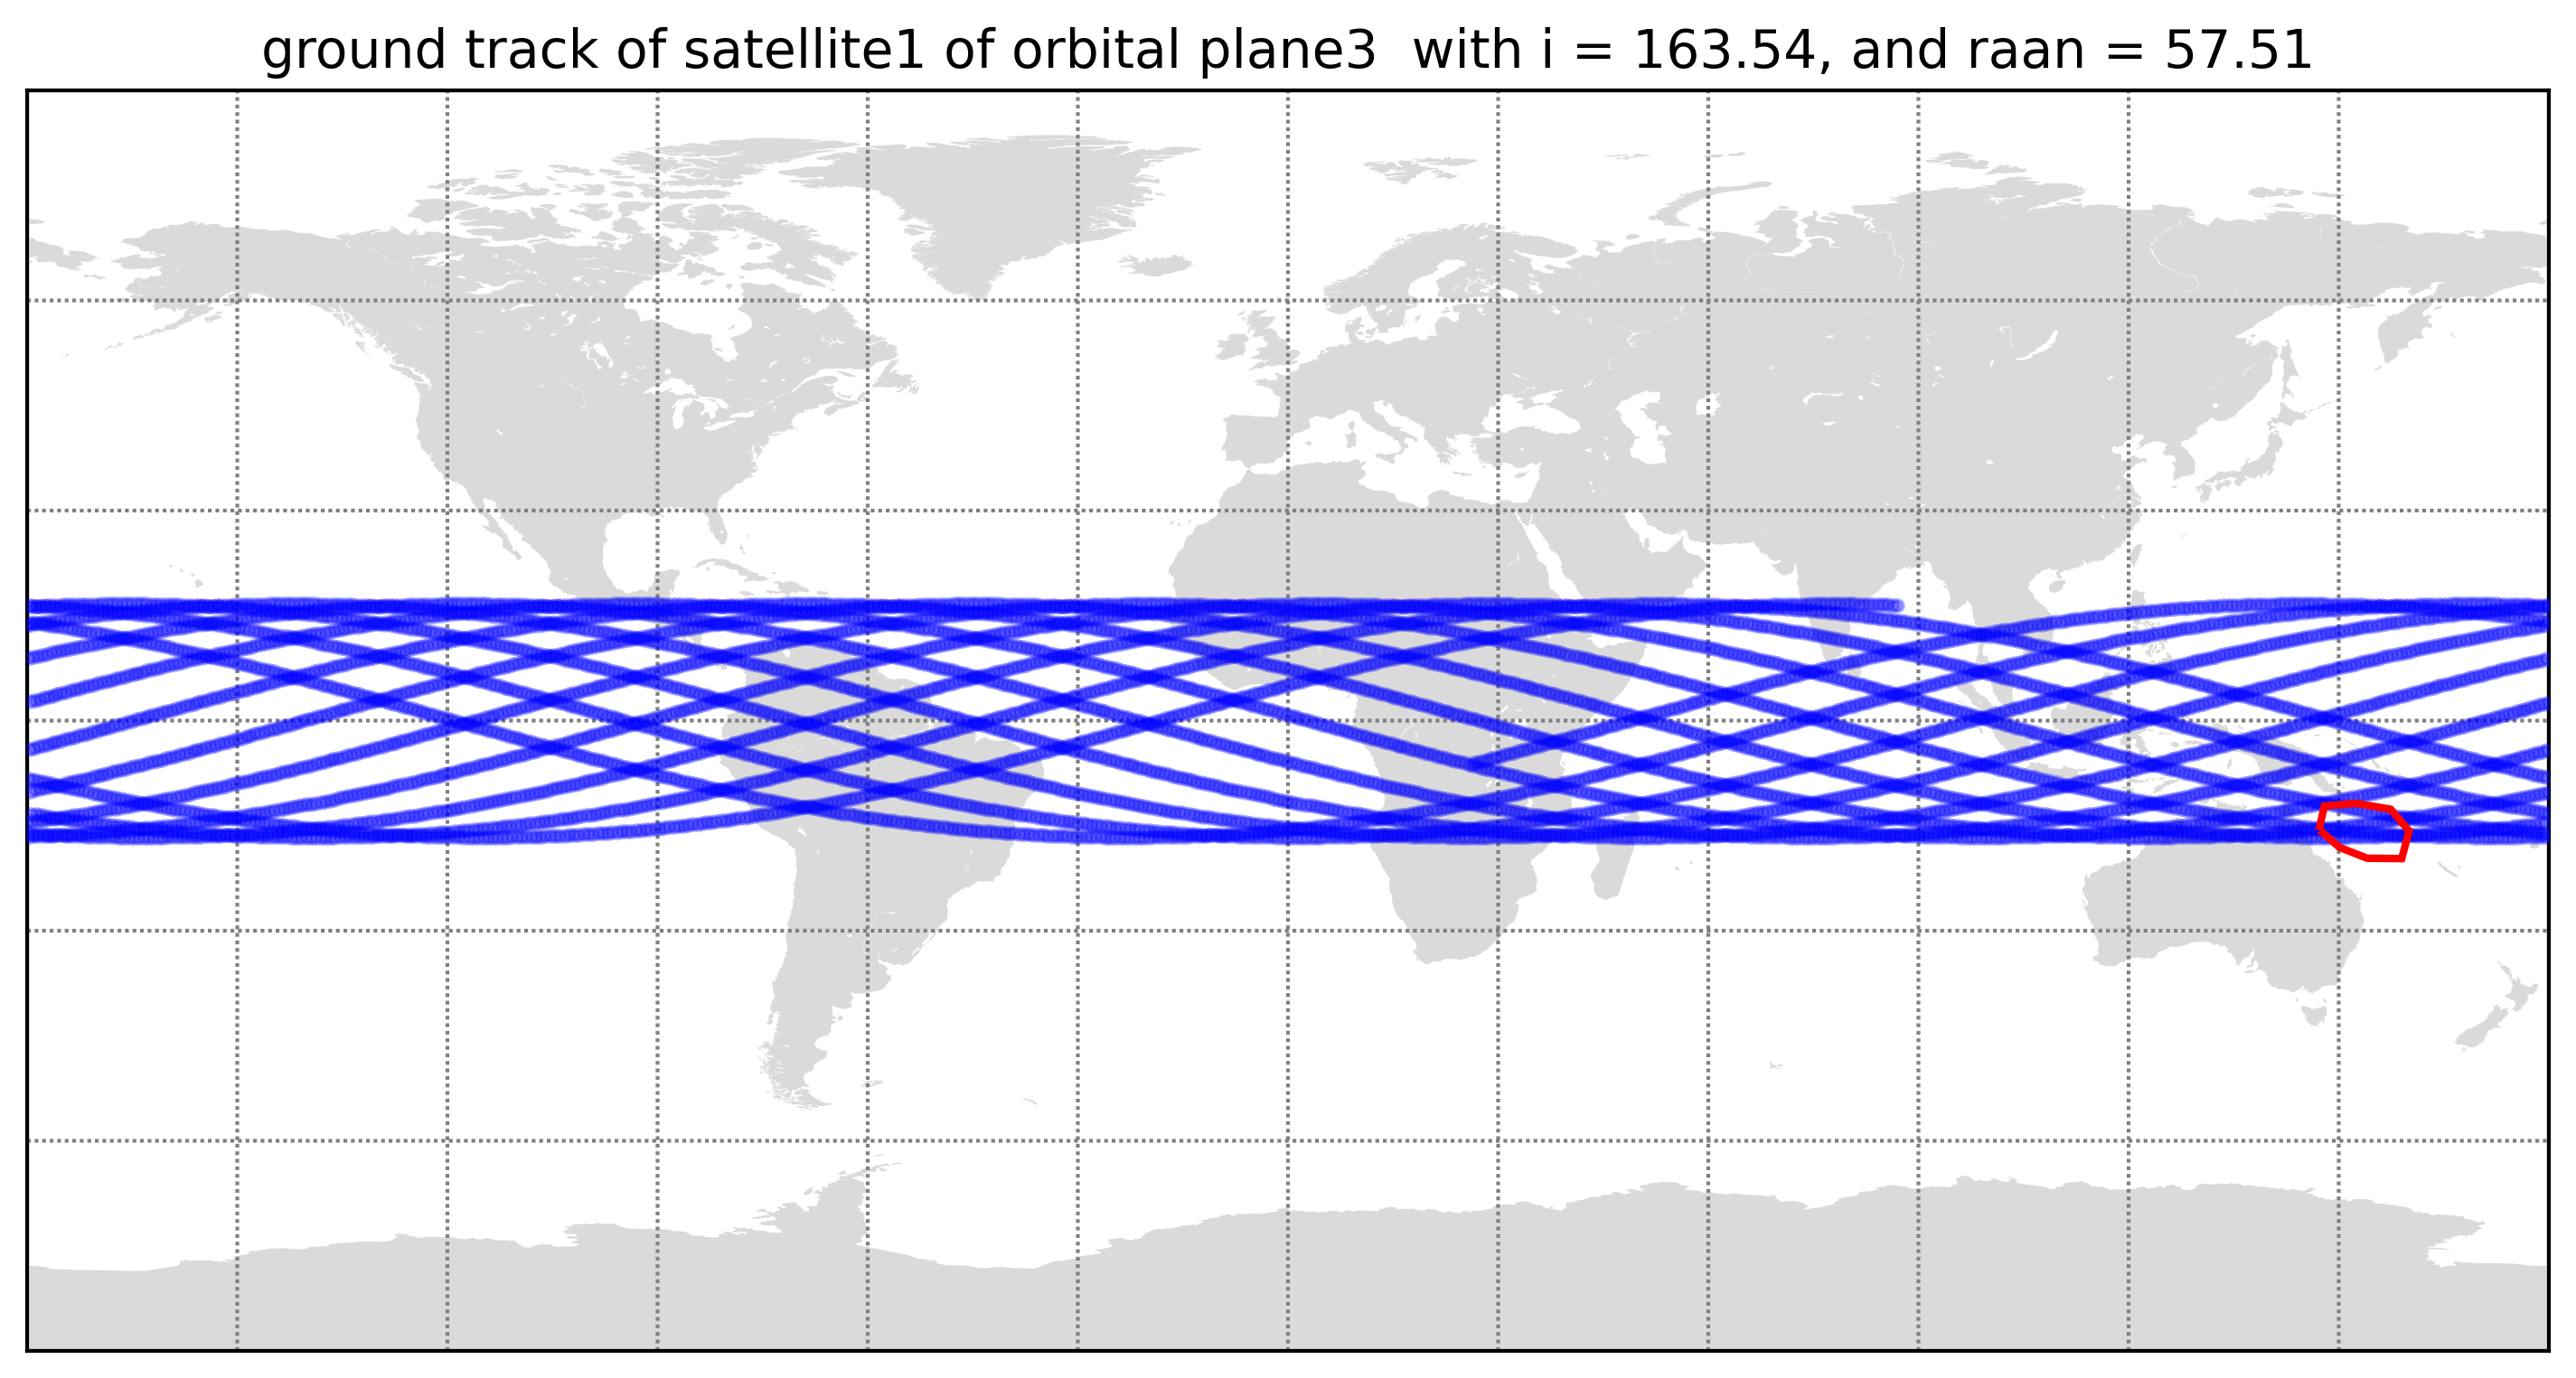

In [22]:
# lets check the ground plot for satellite constellation with inclination range 20-90

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import numpy as np


utc = TimeScalesFactory.getUTC()
epoch = AbsoluteDate(2024,6,1,0,0,0.0,utc)


# Define the polygonal area
westernCentral_partArea_of_Interest = [
    [147.17515827251634, -15.640078251023056],
    [147.94567963567386, -12.187583366380892],
    [152.47710504377255, -11.812564622640394],
    [157.41096167261662, -12.652514202747142],
    [160.04819327494533, -15.759696732458849],
    [158.98519773901563, -19.70058922777251],
    [154.059202587223, -19.649308459193833],
    [150.1129330003555, -18.105241744613366],
    [147.2062653984351, -15.552334895009977]
]



# create the satellites propagator  ##### change the number of plane, satellite per plane, inclination list and raan list as per your optimal values
satellites_test6 = create_walker_delta_constellation_Multi(3,4, [162.82, 162.14, 163.54],[52.97, 59.73, 57.51] )

# lets take 1 satellite from each palne
satellites = [satellites_test6[0], satellites_test6[4], satellites_test6[8]]
# plot the map and groundtrack of satellite using matplotlib
duration = 60.0 * 60.0 * 20  #* 24.0 #for 1days
epoch = AbsoluteDate(2024,6,1,0,0,0.0,utc)
# print("number of satellites propagator we have: ", len(satellites_test6))
    
long_satellite, lat_satellite = orbit_propagationGT(satellites[2], epoch, duration, earth, inertialFrame)


fig = plt.figure(figsize=(12, 8), dpi=300)

m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()     # fill_color='aqua')
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray') 
# Plot satellite ground track
m.scatter(long_satellite, lat_satellite, alpha=0.3, color='blue', zorder=3, marker='.')

# Plot the polygon area
polygon = Polygon(westernCentral_partArea_of_Interest, closed=True, edgecolor='red', facecolor='none', linewidth=2, zorder=4)
plt.gca().add_patch(polygon)


plt.title("ground track of satellite1 of orbital plane3  with i = 163.54, and raan = 57.51", fontsize=14)
plt.savefig('ground_plot_test6_angle_range_120_170_3')
plt.show()



